In [1]:
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.patches import Polygon
from dbfread import DBF
from mpl_toolkits.basemap import Basemap
from sea_ice_model import *
from HaiYangData import *

import shapefile
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt
import io
import cv2
import glob
import cv2
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# define a function which returns an image as numpy array from figure




def draw_aari_icetype(file,save_path = None):
    fig = plt.figure(figsize=(9, 9))
    ax1 = fig.add_subplot(111)
    fig.set_tight_layout(True) # reduce the spaces from margin outside the axis 
    # ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
    m = Basemap(projection='npaeqd', boundinglat=66, lon_0=90., resolution='i')
    m.drawmapboundary()
    

    shp_info = m.readshapefile(file,'aari_arc',drawbounds=False)
    colors = {8:'y',82: 'b',83:'blueviolet',86:'g',95:'brown'}

    for info, shp in zip(m.aari_arc_info, m.aari_arc):
        type_a = int(info['SA'])
        fast_ice = int(info['FA'])
        if type_a in colors.keys():
            poly = Polygon(shp, facecolor=colors[type_a], lw=0,ls=None)  
            ax1.add_patch(poly)
        if fast_ice in colors.keys():
            poly = Polygon(shp, facecolor=colors[fast_ice], lw=0,ls=None)  
            ax1.add_patch(poly)
    m.fillcontinents(color='white')
    if save_path:
        plt.savefig(save_path,dpi=180,bbox_inches='tight',pad_inches = 0, edgecolor = 'white')
#     plt.show()
    return fig

def get_img_from_fig(fig, dpi=180):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=180)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
    
def add_img_color(image_arr):
    new_aari_array = np.full(shape=(image_arr.shape[:2]),fill_value=0)
    for i in range(3):
        new_aari_array += image_arr[:,:,i]
    return new_aari_array

def recode_aari_mask(pic):
    pic[pic < 4] = 0
    pic[pic == 765] = 0 # no data
    pic[pic == 128] = 1 # FYI
    pic[pic == 249] = 2 # old ice
    pic[pic == 382] = 3 # fast ice
    pic[pic == 407] = 4 # young ice
    pic[pic>4] = 0
    return pic

In [3]:
aari_path = r'E:\\python_workfile\\sea_ice_classification\\data\\mask\\aari\\'
dir_path = r'H:\\remote_sensing_data\\sea_ice_type\\aari\\'
files = glob.glob(dir_path + '*.shp')

In [4]:
for file in files[86:]:
    file = file.split('.')[0]
    day = file.split('_')[-3]
    try:
        fig = draw_aari_icetype(file,save_path=aari_path + 'pic\\' + str(day) + '.png')
        plot_img_np = get_img_from_fig(fig)
        plot_img_np = add_img_color(plot_img_np)
        plot_img_np = recode_aari_mask(plot_img_np)
        np.save((aari_path + 'npy\\' + str(day) + '.npy'), plot_img_np)
        print(day)
    except ValueError:
        print(day)
        continue


# 投影提取了南北纬信息的shape文件

In [5]:
def coincident_point_mean(dataframe,value,resolution, grid_array = None,get_count=False):
    if grid_array is None:
        grid_array = np.full((aari.nlat, aari.nlon),fill_value=0)
    for index in dataframe.index:
        x = int(dataframe.projlons[index] / resolution)
        y = int(dataframe.projlats[index] / resolution)
        grid_array[x][y] = dataframe[value][index]
    
    return grid_array

def polar_plot(x_map, y_map,grid, color_lable=None,title=None,cmap = plt.cm.jet):
    plt.figure(figsize=(15,15))
    m = Basemap(projection='npaeqd', boundinglat=66, lon_0=90., resolution='i')
    m.pcolormesh(x_map, y_map, data=grid, cmap=cmap,latlon = True)
    cb = m.colorbar(location='bottom')
    if color_lable:
        cb.set_label(color_lable)
    m.fillcontinents()
    m.drawmapboundary()
    m.drawparallels(np.arange(-90., 120., 10.), labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
    plt.title(title)

def proj_aari_icetype(x_map,y_map,grid,save_path = None):
    fig = plt.figure(figsize=(9, 9))
    fig.set_tight_layout(True)
    m = Basemap(projection='npaeqd', boundinglat=66, lon_0=90., resolution='i')
    m.pcolormesh(x_map,y_map,grid, cmap=plt.cm.jet,latlon = True)
    m.fillcontinents(color='white')
    if save_path:
        plt.savefig(save_path,dpi=180,bbox_inches='tight',pad_inches = 0, edgecolor = 'white')
#     plt.show()
    plt.close()
    return fig

def recode_aari(grid):
    grid[grid == -9] = 0 # no data
    grid[grid == 0] = 0 # ice free
    grid[grid == 82] = 1 # nilas
    grid[grid == 83] = 2 # young ice
    grid[grid == 86] = 3 # FYI
    grid[grid == 95] = 4 # old ice
    grid[grid == 99] = 5 # fast ice
#     grid[grid == 8] = 1
    
    return grid


def get_img_from_fig(fig, dpi=180):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=180)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
    
def add_img_color(image_arr):
    new_aari_array = np.full(shape=(image_arr.shape[:2]),fill_value=0)
    for i in range(3):
        new_aari_array += image_arr[:,:,i]
    return new_aari_array

def recode_aari_mask(pic):
    pic[pic < 4] = 0
    pic[pic == 764] = 0 # no data
    pic[pic == 502] = 1 # FYI
    pic[pic == 403] = 2 # old ice
    pic[pic == 128] = 3 # fast ice
    pic[pic == 384] = 4 # young ice
    pic[pic>4] = 0
    return pic

In [6]:
save_dir_path = r'D:\python_workfile\sea_ice_classification\data\mask\aari\proj\pic'
files = glob.glob(r'F:\remote_sensing_data\AARI' + '\\*.dbf')

In [7]:
satellite = r'AARI'
sensor = r'AARI'
resolution = 30000
hy_sca = HaiYangData(satellite=satellite, sensor=sensor,resolution=resolution)
# 将WGS 84坐标（4326）转化为极射投影
crs = CRS.from_epsg(4326)
crs = CRS.from_string("epsg:4326")
crs = CRS.from_proj4("+proj=latlon")
crs = CRS.from_user_input(4326)
crs2 = CRS(proj="aeqd")
transformer = HaiYangData.set_transformer(crs,crs2)
transformer_back = HaiYangData.set_transformer(crs2,crs)


In [8]:
x_map, y_map = hy_sca.get_map_grid(transformer_back)

In [9]:
FI = mpatches.Patch(color='maroon', label='Fast Ice')
OI = mpatches.Patch(color='orange', label='Old Ice')
FYI = mpatches.Patch(color='lime', label='First Year Ice')
YI = mpatches.Patch(color='dodgerblue', label='Young Ice')
N = mpatches.Patch(color='midnightblue', label='Nilas')


In [10]:
x_map.shape

(1333, 1333)

In [11]:
for file in files:
    day = file.split('\\')[-1].split('.')[0]
    try:
        table = DBF(file)

        aari_df = pd.DataFrame(table)

        aari = HaiYangData(satellite='hy', sensor='alt',resolution=resolution)
        aari_x_map,aari_y_map = aari.get_map_grid(transformer_back)

        aari_df["lat"] = aari_df["Field1"]
        aari_df["lon"] = aari_df["Field2"]
        aari.add_proj(aari_df, transformer)
        # 将投影数据添加到dataframe中
        aari_grid = coincident_point_mean(aari_df,'SA',resolution)
        # aari_grid = coincident_point_mean(aari_df,'FA',resolution,grid_array=aari_grid)
        aari_grid = recode_aari(aari_grid)
        # 绘制真值
        fig = plt.figure(figsize=(9, 9))
        fig.add_subplot(111)
        fig.set_tight_layout(True) # reduce the spaces from margin outside the axis 

        hy_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=90., resolution='c')
        hy_m.pcolor(x_map, y_map, data=aari_grid, cmap=plt.cm.jet,shading = 'auto',vmax=5,vmin=1,latlon = True)

        hy_m.fillcontinents()
        hy_m.drawmapboundary()
        hy_m.drawparallels(np.arange(-90., 120., 10.), labels=[1, 0, 0, 0])
        hy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
        plt.title('True mask '+str(day))
        plt.legend(loc='upper right',handles=[FI,OI ,FYI, YI ,N], title='Ice Type')
        plt.savefig(save_dir_path+'\\ '+str(day)+'.png')
        plt.close()
        
#         np.save((r'E:\\python_workfile\\sea_ice_classification\\data\\mask\\aari\\proj\\grid_npy\\'+day+'.npy'), aari_grid)
        print(day)
    
    except ValueError:
        print(day)
        continue

KeyboardInterrupt: 

# 重新投影AARI数据

In [1]:
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.patches import Polygon

import shapefile
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt
import io
import cv2
import glob
import cv2

from dbfread import DBF
import pandas as pd
from PIL import Image

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from sea_ice_model import *
from HaiYangData import *

In [2]:
aari_npy_files = glob.glob(r'F:\python_workspace\sea_ice_classification\data\mask\aari\proj\grid_npy' + '\\*.npy')
# aari_npy_files = glob.glob(r'F:\python_workspace\sea_ice_classification\data\mask\aari\npy' + '\\*.npy')


In [3]:
satellite = r'AARI'
sensor = r'AARI'
resolution = 25000
hy_sca = HaiYangData(satellite=satellite, sensor=sensor,resolution=resolution)
# 将WGS 84坐标（4326）转化为极射投影
crs = CRS.from_epsg(4326)
crs = CRS.from_string("epsg:4326")
crs = CRS.from_proj4("+proj=latlon")
crs = CRS.from_user_input(4326)
crs2 = CRS(proj="aeqd")
transformer = HaiYangData.set_transformer(crs,crs2)
transformer_back = HaiYangData.set_transformer(crs2,crs)

x_map, y_map = hy_sca.get_map_grid(transformer_back)

In [4]:
def get_array_from_grid(grid):
    fig = plt.figure(figsize=(7,7))
    hy_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=90., resolution='c')
    hy_m.pcolormesh(x_map, y_map, data=grid, cmap=plt.cm.jet,vmax=5,vmin=0,shading='auto', latlon = True)
    plt.axis('off')
    return get_img_from_fig(fig)

In [5]:
def recode_aari_mask_R_add_G(pic):
    pic[pic == 254] = 0 # no data
    pic[pic == 77] = 1 # nials
    pic[pic == 40] = 2 # young ice
    pic[pic == 205] = 3 # FYI
    pic[pic == 103] = 4 # old ice
    pic[pic == 128] = 5 # fast ice
    return pic

C:\Users\user\AppData\Local\Temp/ipykernel_26652/780634833.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  hy_m.pcolormesh(x_map, y_map, data=aari_grid, cmap=plt.cm.jet,vmax=5,vmin=0,shading='auto', latlon = True)
C:\Users\user\AppData\Local\Temp/ipykernel_26652/804448636.py:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  hy_m.pcolormesh(x_map, y_map, data=grid, cmap=plt.cm.jet,vmax=5,vmin=0,shading='auto', latlon = True)
C:\Users\user\AppData\Local\Temp/ipykernel_26652/780634833.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are no

C:\Users\user\AppData\Local\Temp/ipykernel_26652/780634833.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  hy_m.pcolormesh(x_map, y_map, data=aari_grid, cmap=plt.cm.jet,vmax=5,vmin=0,shading='auto', latlon = True)
C:\Users\user\AppData\Local\Temp/ipykernel_26652/804448636.py:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  hy_m.pcolormesh(x_map, y_map, data=grid, cmap=plt.cm.jet,vmax=5,vmin=0,shading='auto', latlon = True)
C:\Users\user\AppData\Local\Temp/ipykernel_26652/780634833.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are no

C:\Users\user\AppData\Local\Temp/ipykernel_26652/780634833.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(7,7))
C:\Users\user\AppData\Local\Temp/ipykernel_26652/780634833.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  hy_m.pcolormesh(x_map, y_map, data=aari_grid, cmap=plt.cm.jet,vmax=5,vmin=0,shading='auto', latlon = True)
C:\Users\user\AppData\Local\Temp/ipykernel_26652/804448636.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

C:\Users\user\AppData\Local\Temp/ipykernel_26652/780634833.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  hy_m.pcolormesh(x_map, y_map, data=aari_grid, cmap=plt.cm.jet,vmax=5,vmin=0,shading='auto', latlon = True)
C:\Users\user\AppData\Local\Temp/ipykernel_26652/804448636.py:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  hy_m.pcolormesh(x_map, y_map, data=grid, cmap=plt.cm.jet,vmax=5,vmin=0,shading='auto', latlon = True)
C:\Users\user\AppData\Local\Temp/ipykernel_26652/780634833.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are no

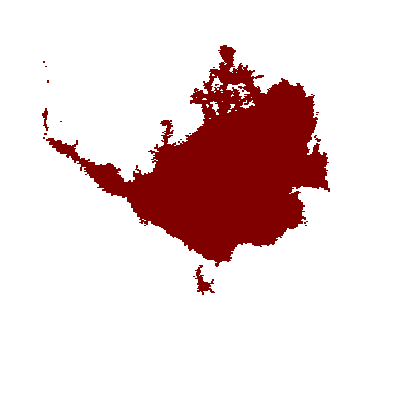

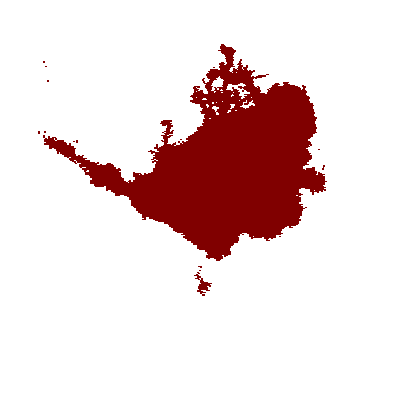

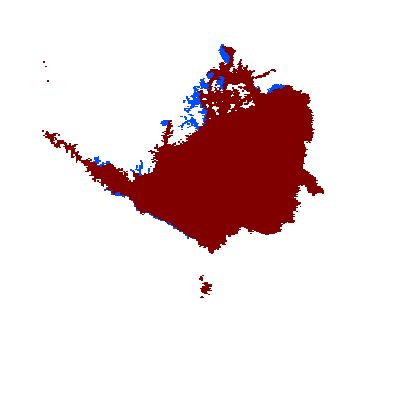

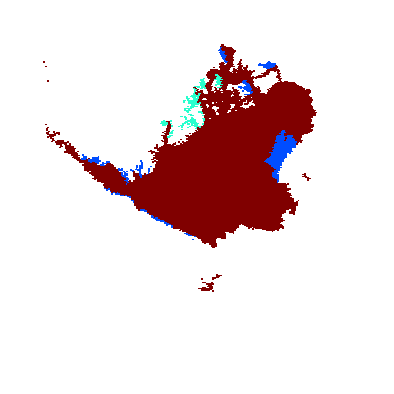

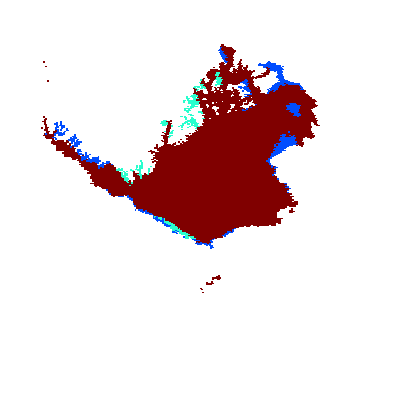

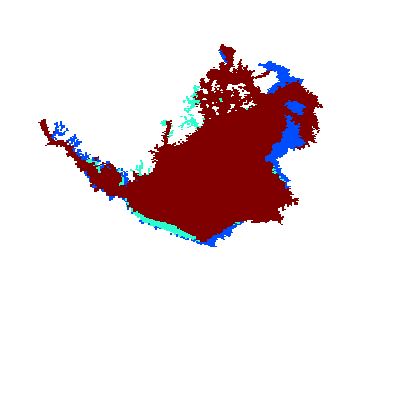

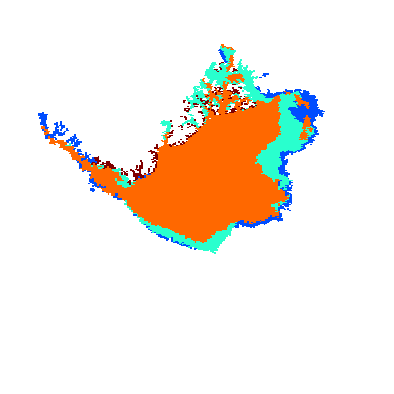

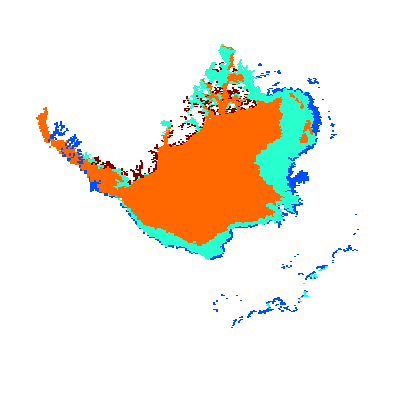

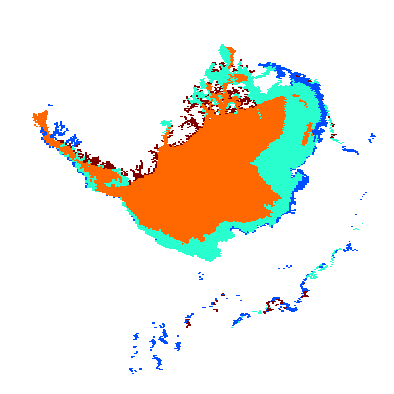

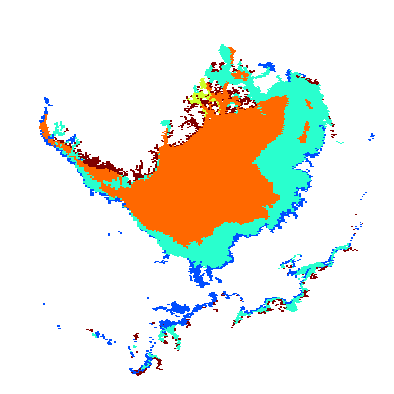

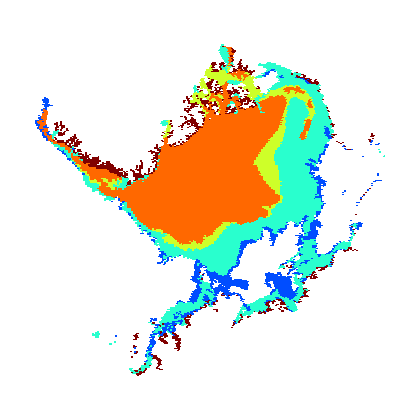

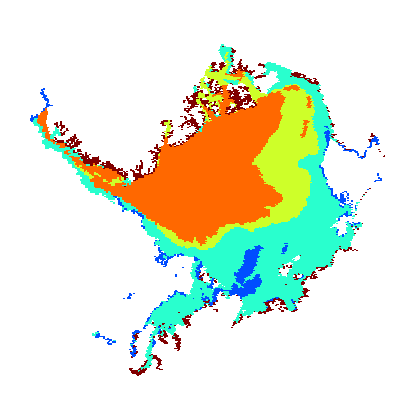

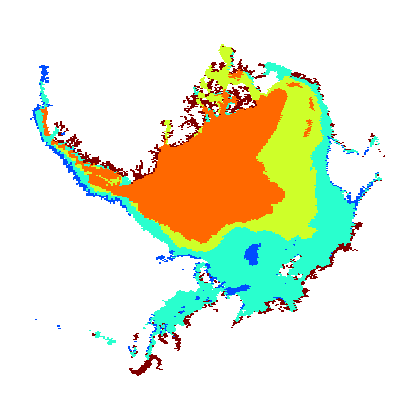

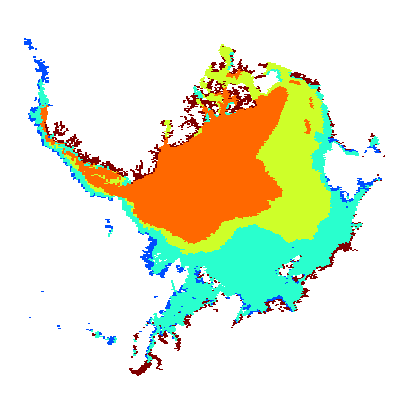

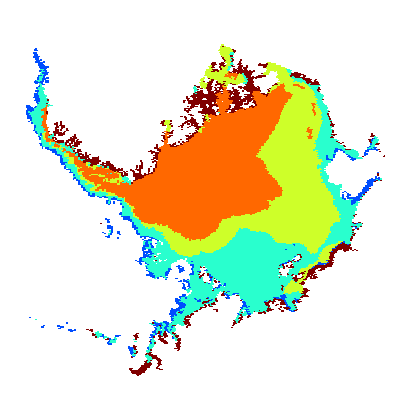

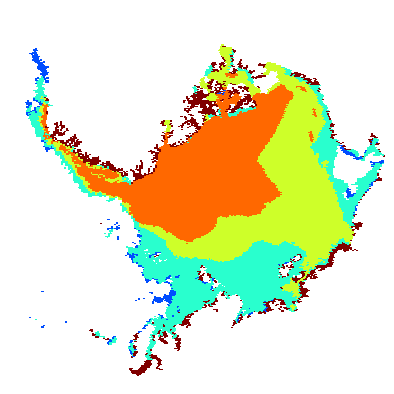

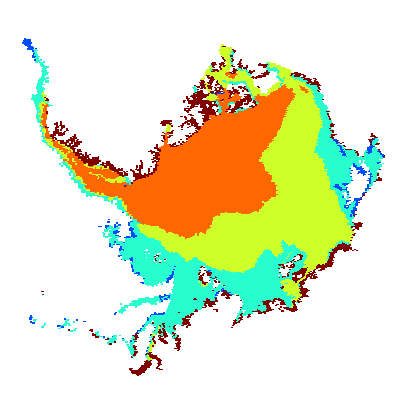

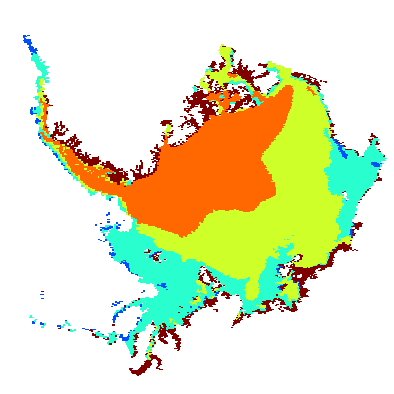

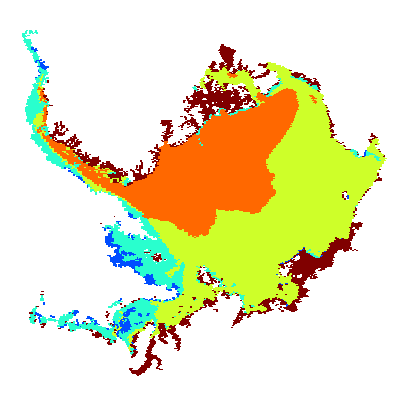

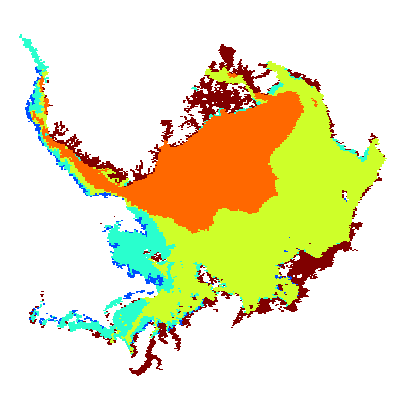

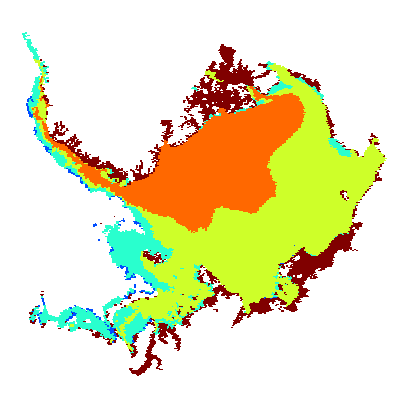

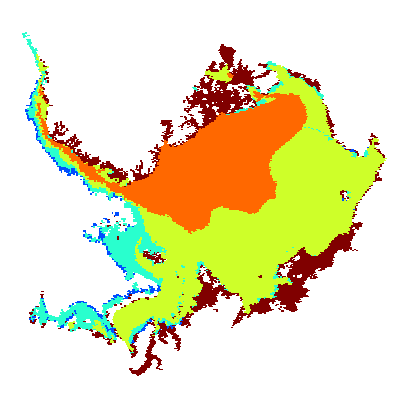

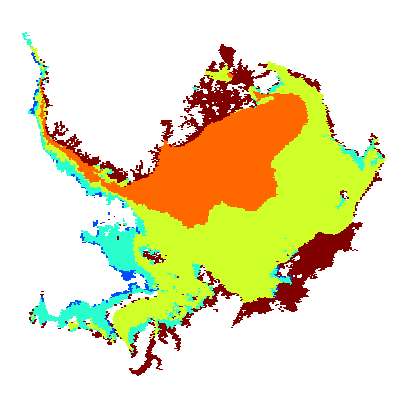

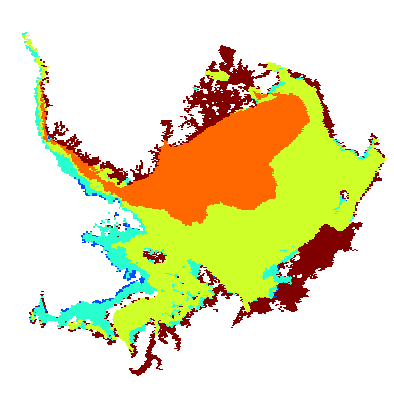

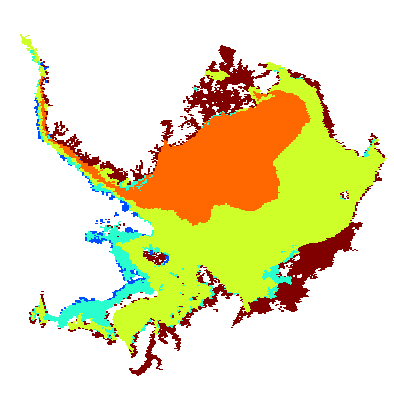

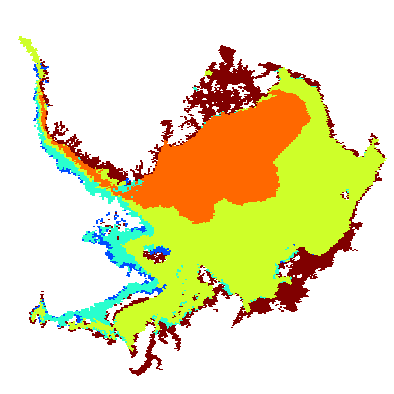

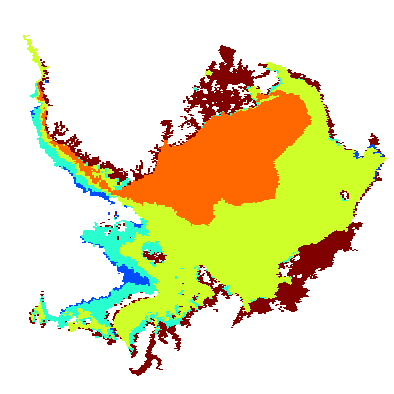

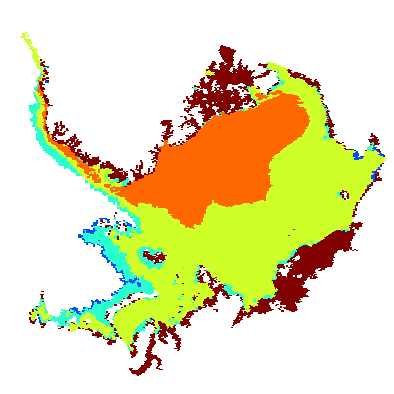

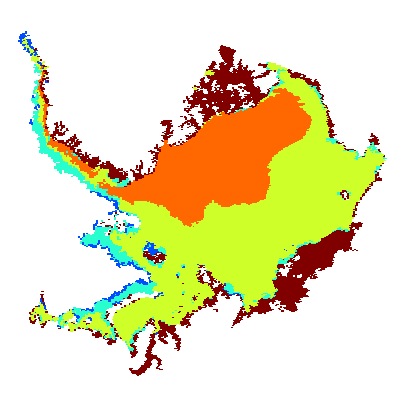

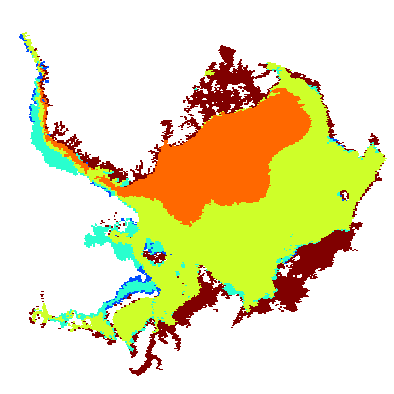

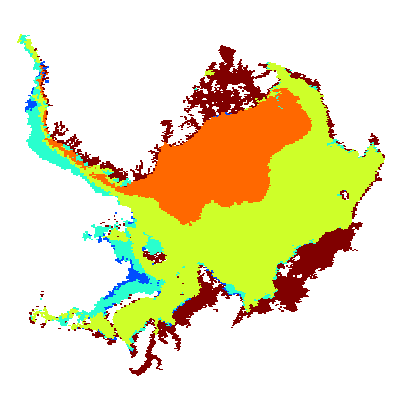

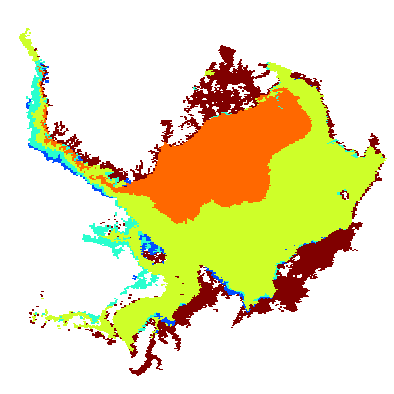

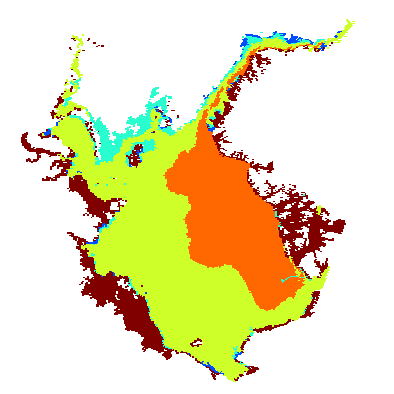

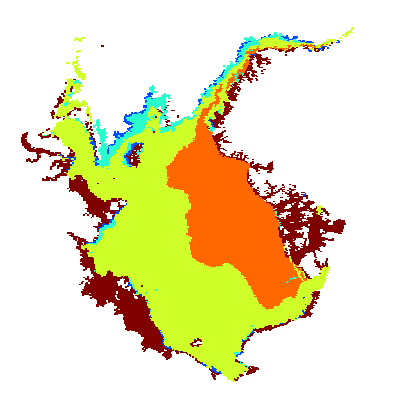

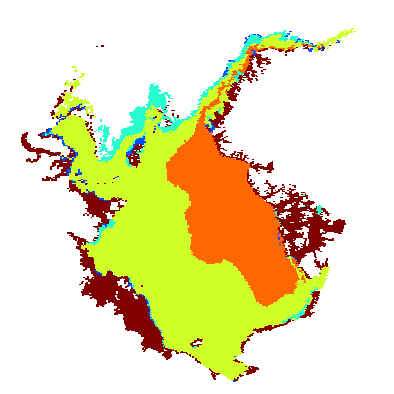

In [6]:
for aari_npy_file in aari_npy_files[131:]:
    name = aari_npy_file.split('\\')[-1].split('.')[0]
    aari_grid = np.load(aari_npy_file)
    aari_grid = aari_grid.astype('float32')
    aari_grid[aari_grid == 0] = np.nan
    fig = plt.figure(figsize=(7,7))
    hy_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=90., resolution='c')
    hy_m.pcolormesh(x_map, y_map, data=aari_grid, cmap=plt.cm.jet,vmax=5,vmin=0,shading='auto', latlon = True)
    plt.axis('off')
    plot_img_np = get_img_from_fig(fig)
    plt.close()
    plot_img_np = get_array_from_grid(aari_grid)
    plot_img_np = plot_img_np[:,:,0]+plot_img_np[:,:,1]
    plot_img_np = recode_aari_mask_R_add_G(plot_img_np)
    img = Image.fromarray(plot_img_np)
    img.save(r'E:\python_workfile\sea_ice_classification\training7\dataset\aari\pic'+f'\\{name}.png')
#     np.save(r'E:\python_workfile\sea_ice_classification\training7\dataset\aari'+f'\\{name}.npy',plot_img_np)